# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

device = torch.device('cpu')
# training on GPU in not awailable right now



In [72]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
        array = array.reshape(1, self.height,self.width)

        image = torch.tensor(array, device=device)
        label = torch.tensor(label,device=device)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [114]:
# transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=1),
#         transforms.RandomRotation(degrees=45),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomGrayscale(p=0.1)
#     ]),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]) normalize images
# ])

# color_transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=0.4),
#         transforms.ColorJitter(brightness=0.5),
#         transforms.ColorJitter(brightness=0.6),
#         transforms.ColorJitter(brightness=0.7)
#     ]),
#     transforms.ToTensor()
# ])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=45),
        transforms.RandomRotation(degrees=60),
        transforms.RandomRotation(degrees=75)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.2, p=1)
    ]),
    transforms.ToTensor()
])

In [115]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations)
print(dataset)

910, 102


C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


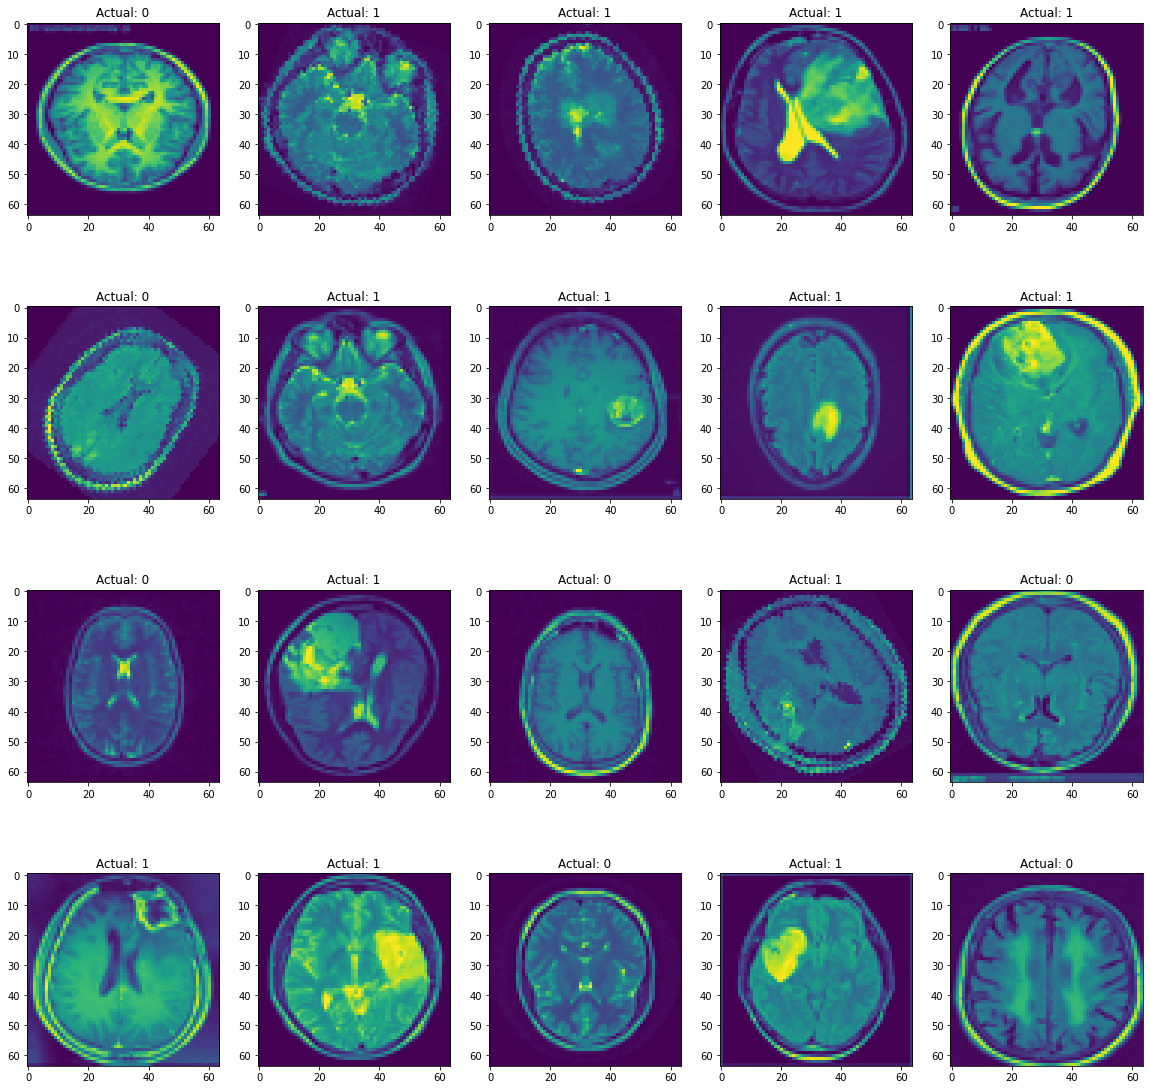

In [119]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.9)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [51]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [120]:
model = BrainTumorModel(torch_ref=torch)
print(model)

C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


Epochs: 0 Loss: 25.25558090209961
Epochs: 10 Loss: 0.5587510466575623
Epochs: 20 Loss: 0.5444270968437195
Epochs: 30 Loss: 0.4939052164554596
Epochs: 40 Loss: 0.4772406220436096


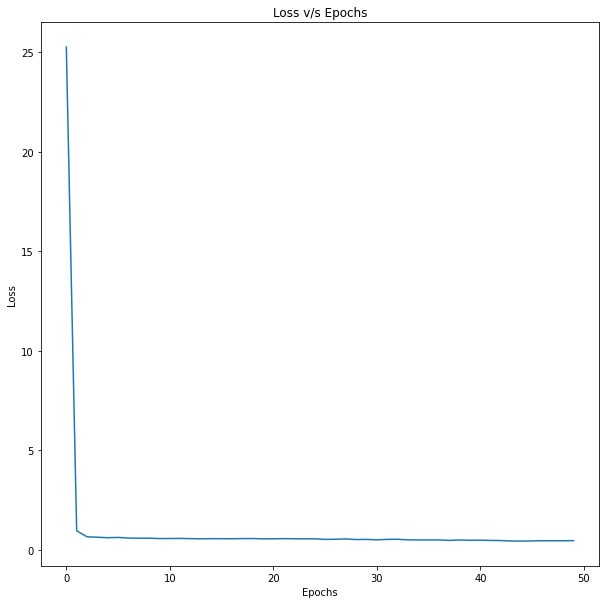

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
plot = True

def train(model, dataset, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
        if epoch%10 == 0:
            print(f'Epochs: {epoch} Loss: {total_loss/i}')
        loss_list.append(total_loss/batch_size)
    return loss_list
loss_list = train(model, dataset, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [124]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n '
          f'Test Loss: {test_loss/number_of_imags: .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=32)
test(model, test_loader, loss_fn)

C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


Test Accuracy: 0.79 
 Test Loss:  0.50


(2.0082808136940002, tensor(3.1771))

C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


tensor([[ 1.4481, -1.4508]], grad_fn=<AddmmBackward>)
tensor([[-0.0439,  0.0323]], grad_fn=<AddmmBackward>)
tensor([[-0.4632,  0.4886]], grad_fn=<AddmmBackward>)
tensor([[-0.6336,  0.6688]], grad_fn=<AddmmBackward>)
tensor([[-1.0779,  1.0846]], grad_fn=<AddmmBackward>)
tensor([[-0.0439,  0.0323]], grad_fn=<AddmmBackward>)
tensor([[ 1.0953, -1.0741]], grad_fn=<AddmmBackward>)
tensor([[-1.4513,  1.4511]], grad_fn=<AddmmBackward>)
tensor([[-3.2986,  3.3132]], grad_fn=<AddmmBackward>)
tensor([[-0.2497,  0.2392]], grad_fn=<AddmmBackward>)
tensor([[ 0.8188, -0.8551]], grad_fn=<AddmmBackward>)
tensor([[-0.0439,  0.0323]], grad_fn=<AddmmBackward>)
tensor([[-0.0439,  0.0323]], grad_fn=<AddmmBackward>)
tensor([[-0.8019,  0.7972]], grad_fn=<AddmmBackward>)
tensor([[ 1.7885, -1.8083]], grad_fn=<AddmmBackward>)
tensor([[ 0.8553, -0.8729]], grad_fn=<AddmmBackward>)
tensor([[ 0.1121, -0.1125]], grad_fn=<AddmmBackward>)
tensor([[ 0.9172, -0.9322]], grad_fn=<AddmmBackward>)
tensor([[-2.4966,  2.5177]],

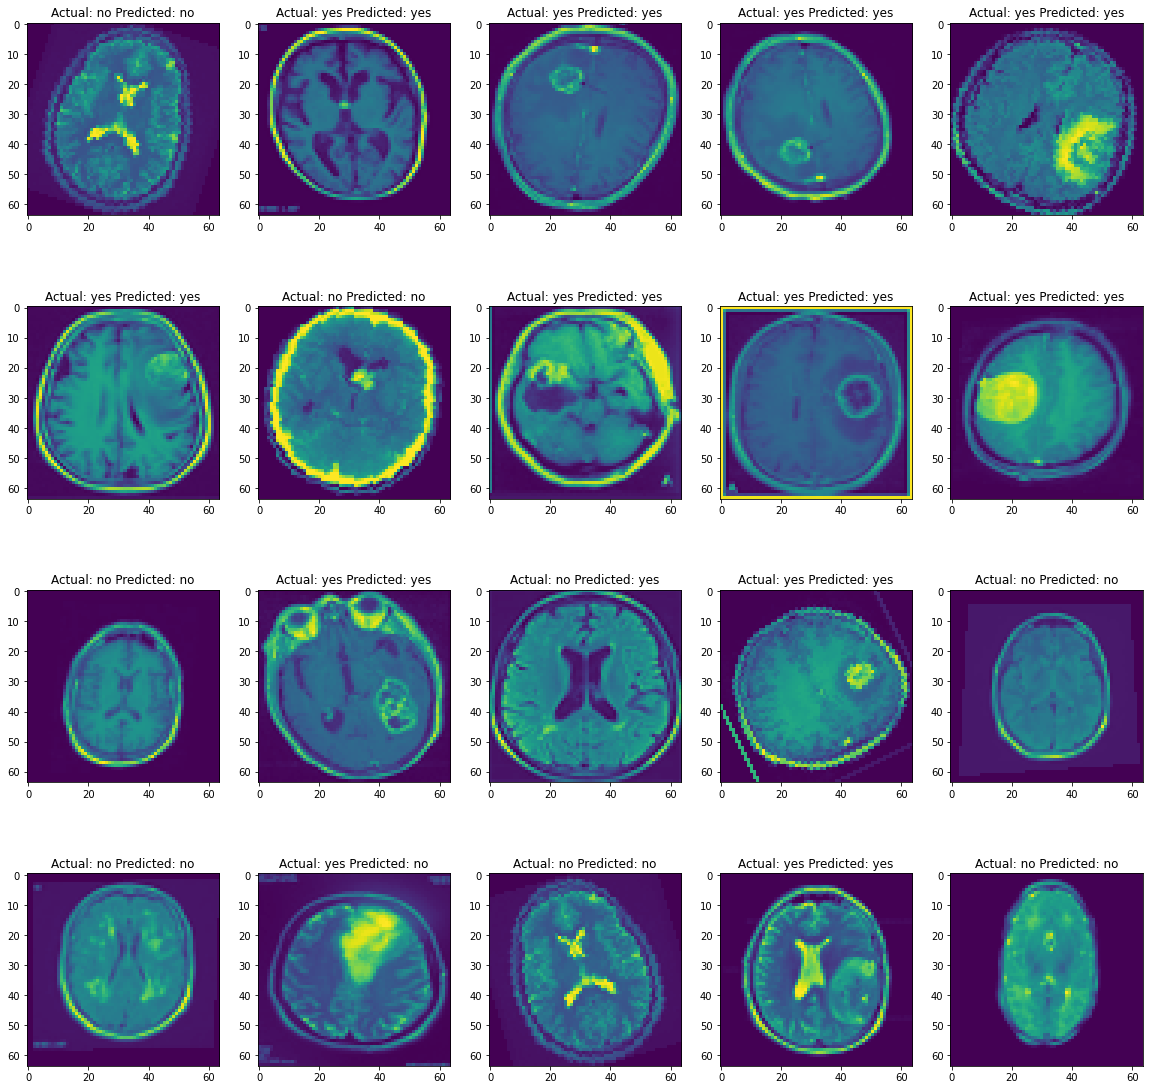

In [130]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()

### SyMPC part


In [131]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [141]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

    split_size = int(len(data)/len(session.parties))+1
    # for batch in data_loader:
    #     ptr = batch.share(session=session)
    #     image_pointers.append(ptr)

    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        image_pointers.append(ptr)

    return image_pointers

In [133]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [137]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)
    if i == 10: break
ptrs


C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,


In [142]:
# advanced split data
imgs, lbls = next(iter(test_loader))
a_ptrs = split_send(imgs, session=session)

a_ptrs


C:\Users\ollyt\AppData\Local\Temp/ipykernel_15096/3743141504.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


[[MPCTensor]
 Shape: torch.Size([17, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([15, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]

In [143]:
mpc_model = model.share(session)
mpc_model

In [21]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(a_ptrs)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

C:\Users\ollyt\anaconda3\envs\pysyft\lib\site-packages\sympc\protocol\fss\fss.py:140: UserWarning: Temporarily disabling CUDA as FSS does not support it
  warnings.warn("Temporarily disabling CUDA as FSS does not support it")
[2021-11-09T22:13:46.807971+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89ed109aaab349db993fa75254736aca>.
[2021-11-09T22:13:46.810973+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d18e5b7a555e4784ae3cb91ea14b4b02>.
[2021-11-09T22:14:58.974550+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74a907bf120440918928322101515c91>.
[2021-11-09T22:14:58.977784+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4a64f862b5142fba034339f0f70a96b>.
[2021-11-09T22:15:32.846809+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memo

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1486.1824, -1462.5040]])


[2021-11-09T22:15:43.078135+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9f2f879ad194c4b9c9c6461134632fc>.
[2021-11-09T22:15:43.081101+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b91c2c3629b4998bbc71f7bc7305c6e>.
[2021-11-09T22:15:43.085101+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c576a0f566e4f7a996dbc11f6926074>.
[2021-11-09T22:15:43.087102+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff632e8108764409b74a80ec96a41b3f>.
[2021-11-09T22:16:49.042922+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16066fe836c84cf29e343a3c885619ca>.
[2021-11-09T22:16:49.044923+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39a9ce7868834bc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3677.3386, -3824.3909]])


[2021-11-09T22:17:31.938464+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 715ab689fe7e438ba51786e278a00347>.
[2021-11-09T22:17:31.940432+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b4cf5d3783341edbaec1157a62247b5>.
[2021-11-09T22:17:31.946186+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53547bbaa2d04f7782c2900aa9b9b72c>.
[2021-11-09T22:17:31.948151+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d456e6299fe34ff791207e4dbaa38fb7>.
[2021-11-09T22:17:31.956210+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bebea1567878417c8b3315f06485b3b1>.
[2021-11-09T22:17:31.959288+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18789aa23ad0425

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3132.5674, -3241.1104]])


[2021-11-09T22:19:15.086399+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a336baa47dbe449fb69dd4ae3c01c093>.
[2021-11-09T22:19:18.521245+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1eb71a49210a4d779205d024fc0dc1e5>.
[2021-11-09T22:19:18.523432+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7cddd24273f497898479c0402ad67f3>.
[2021-11-09T22:20:24.736900+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 247fe2f2ccbf4deba78c49deee9e11dd>.
[2021-11-09T22:20:24.738967+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 26fc304522e54c42998f12b8d6c56d82>.
[2021-11-09T22:20:58.294990+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38742da4f9b643e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1665.6007, -1649.4934]])


[2021-11-09T22:21:08.657103+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c492c94e2e942138957f0485642426c>.
[2021-11-09T22:21:08.660105+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d7824f1f8b04382a5db145f66e8d41e>.
[2021-11-09T22:21:08.666103+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e51bad0d6fc84effb7437799995da9dc>.
[2021-11-09T22:21:08.668138+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c45f211ac9484bac94030ca5c3a85b50>.
[2021-11-09T22:21:08.870158+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5085774828be46bbbef41056c962b879>.
[2021-11-09T22:21:08.873258+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ebb7158786549e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2850.6477, -2827.0056]])


[2021-11-09T22:22:57.536715+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87594bbd56954019b96583f275ee1cde>.
[2021-11-09T22:22:57.539716+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ad33ebc824749c1ae67e0fe19ab8f3c>.
[2021-11-09T22:22:57.549714+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 739b24c5e2c54d9eae59253690d52f7e>.
[2021-11-09T22:22:57.551715+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f51e82d8c034a999e291a1a1fb86d70>.
[2021-11-09T22:22:57.555714+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c5157a8a3874c189fc2ef75fca57f53>.
[2021-11-09T22:22:57.559716+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2ae9a39d2ca4d5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 4155.1021, -4202.9829]])


[2021-11-09T22:24:41.204083+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03f3c44d4ea042cabb3ce4308696418a>.
[2021-11-09T22:24:41.220077+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f4f9b5b353747c2b1d4067995382baf>.
[2021-11-09T22:24:41.230869+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da9d8d0b08b5443d819caa61e41f7c76>.
[2021-11-09T22:24:41.236867+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22b95824dbac42af9c89a4987f91ae71>.
[2021-11-09T22:24:41.247651+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b9938daea474707b0ccf6b0ea8bddd5>.
[2021-11-09T22:24:41.250247+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11ce1f4b7c45458

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 52.9891, -93.6876]])


[2021-11-09T22:26:34.159228+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f4853485dee432b8f9e8a1a35d857cc>.
[2021-11-09T22:26:34.162228+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4b62299b21d40b4bf8c30ed5303c30a>.
[2021-11-09T22:26:34.166253+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35d48a8a3af94c11b102ead0698dcb29>.
[2021-11-09T22:26:34.170261+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a2765cc1c1a42b4898d5875573eeb43>.
[2021-11-09T22:26:34.342452+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f60c1ef4fbb04543b0abc06cc9919b91>.
[2021-11-09T22:26:34.344695+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7f33d55340d4cd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3724.2141, -3809.2529]])


[2021-11-09T22:28:22.850273+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46256f96c08549adaaa8fe0855ec05aa>.
[2021-11-09T22:28:22.853233+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3289b94663be4036b5013b89e7ab3c72>.
[2021-11-09T22:28:22.858267+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c21afabfb27145ada07e7e0621ca8446>.
[2021-11-09T22:28:22.860233+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb7e7bb46d514758a6fb611f4f69894e>.
[2021-11-09T22:28:22.869165+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 866306c1d3b342d3b61b6eb98aef0ae4>.
[2021-11-09T22:28:22.871135+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae641119e69148f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 694.9650, -628.4436]])


[2021-11-09T22:30:14.759384+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c5ff345c289946149fd4ce763e784f2d>.
[2021-11-09T22:30:14.762352+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5bf842071ef24217a877d3ac9df20cd9>.
[2021-11-09T22:31:18.305877+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ff40926355c43dcaeed923be9b36fe4>.
[2021-11-09T22:31:18.308835+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9b58de8f1ae448dbe765875335910cc>.
[2021-11-09T22:31:49.939151+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 43ecf728c40147548c236b615f5667a5>.
[2021-11-09T22:31:49.941153+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59b140c256594d6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 524.1373, -574.5623]])


[2021-11-09T22:32:00.863885+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 217d2556bb9c425b9b95f21929881e7c>.
[2021-11-09T22:32:00.865888+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ab618b67c8143d88431ae30a20d6f8f>.
[2021-11-09T22:32:00.872887+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ffcf963df5ec4e84aa18daf777976daf>.
[2021-11-09T22:32:00.874888+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4299ca7e5da741a89fba13208896b6a1>.
[2021-11-09T22:32:00.878889+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ec13e7609e443969b99603b0c17dc1d>.
[2021-11-09T22:32:00.880887+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 205fc32eea4c47d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 534.2399, -487.3203]])


[tensor([[ 1486.1824, -1462.5040]]),
 tensor([[ 3677.3386, -3824.3909]]),
 tensor([[ 3132.5674, -3241.1104]]),
 tensor([[ 1665.6007, -1649.4934]]),
 tensor([[ 2850.6477, -2827.0056]]),
 tensor([[ 4155.1021, -4202.9829]]),
 tensor([[ 52.9891, -93.6876]]),
 tensor([[ 3724.2141, -3809.2529]]),
 tensor([[ 694.9650, -628.4436]]),
 tensor([[ 524.1373, -574.5623]]),
 tensor([[ 534.2399, -487.3203]])]

[2021-11-09T22:33:46.377905+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1aa88c74abc477bbbcd1e52e805ebed>.
[2021-11-09T22:33:46.380253+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb54be28b64047bfbf76a6427d562192>.
[2021-11-09T22:33:46.384930+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 074648124de74a58ae2e228d0937f088>.
[2021-11-09T22:33:46.386784+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ae8e9dfe3b34eed8f32d54576b421da>.
[2021-11-09T22:33:46.394019+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7bc4e37f86642ef9be1410bbc2d66d3>.
[2021-11-09T22:33:46.395953+0100][CRITICAL][logger]][13324] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89e40c5cec9a462

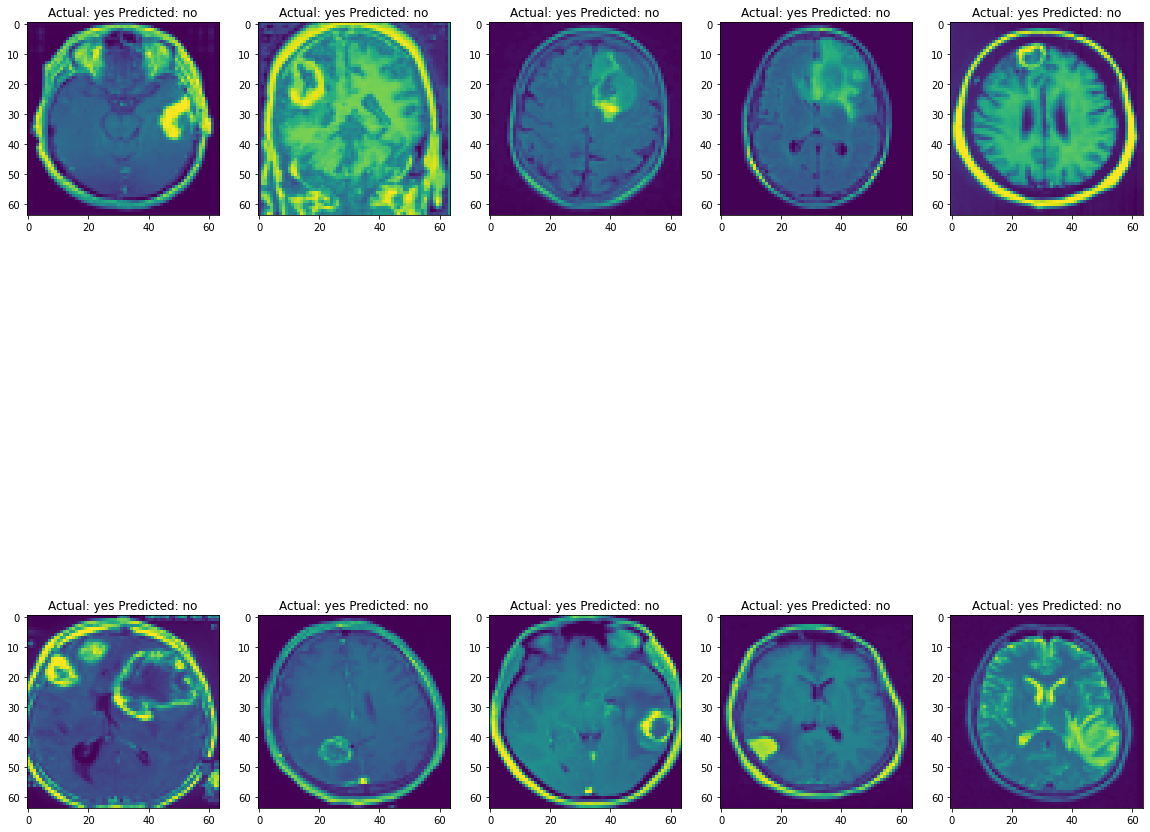

Time for inference: 1203.9492888450623


In [22]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(2,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

TypeError: share() missing 1 required positional argument: 'session'